Import

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

Feature extraction

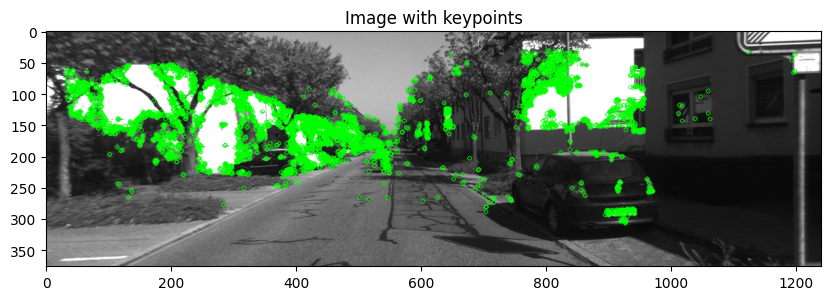

In [2]:
# Load the image
image = cv2.imread('dataset/sequences/00/image_0/000000.png', cv2.IMREAD_GRAYSCALE)

# Initialize orb
orb = cv2.ORB_create(nfeatures = 5000)

# Detect keypoints and compute descriptors
keypoints, descriptors = orb.detectAndCompute(image, None)

# Draw the keypoints in the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0,255,0), flags=0)

# Display the image with keypoints
plt.figure(figsize=(10,10))
plt.imshow(image_with_keypoints, cmap='gray')
plt.title('Image with keypoints')
plt.show()

Feature matching

Matched coordinates of the matched points
Matched points in frame I:
[[183.       180.      ]
 [901.       132.      ]
 [308.       148.      ]
 ...
 [725.76     106.560005]
 [672.        48.      ]
 [579.       174.      ]]
Matched points in frame I+1:
[[173.      183.     ]
 [913.      131.     ]
 [304.      150.     ]
 ...
 [191.52    159.84001]
 [679.       43.     ]
 [716.63635  94.55618]]


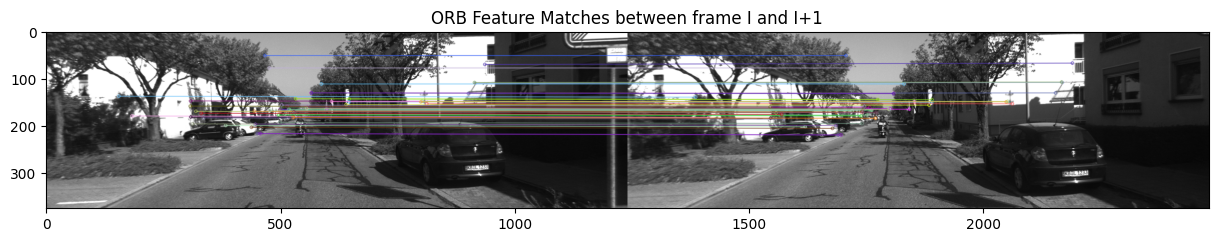

In [3]:
# Load the initial image (frame I)
image1 = cv2.imread('dataset/sequences/00/image_0/000000.png')

# Load the subsequent image (frame I+1)
image2 = cv2.imread('dataset/sequences/00/image_0/000001.png')

# Intialize orb detector
orb = cv2.ORB_create(nfeatures=10000)

# Detect keypoints and compute descriptors for the first image
keypoints1, descriptors1 = orb.detectAndCompute(image1, None)

# Detect keypoints and compute descriptors for the second image
keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

# Initialice the BFMatcher with default params
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort the matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the ntop matches 
top_matches = matches[:50]
matched_img = cv2.drawMatches(image1, keypoints1, image2, keypoints2, top_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the image witch matches
plt.figure(figsize=(15,15))
plt.imshow(matched_img)
plt.title('ORB Feature Matches between frame I and I+1')

# Optionally extract the matched points
matched_points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
matched_points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

# Print the coordinates of the matched points
print("Matched coordinates of the matched points")
print("Matched points in frame I:")
print(matched_points1)
print("Matched points in frame I+1:")
print(matched_points2)



Pose estimation

In [4]:
# pose estimation
K = np.array([[3177.000, 0, 1632.000],
              [0, 3177.000, 1224.00],
              [0,0,1]])

# Optionally, extracted points
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

# Compute the fundamental matrix using RANSAC
F, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Select inliers points
pts1_inliers = pts1[inliers.ravel() == 1]
pts2_inliers = pts2[inliers.ravel() == 1]

# Estimate essential matrix
E = K.T @ F @ K

_, R, t, mask = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)

print('Rotation matrix R:')
print(R)
print('Translation matrix t:')
print(t)



Rotation matrix R:
[[ 0.99995485 -0.00905145 -0.0028926 ]
 [ 0.00906292  0.99995102  0.00397716]
 [ 0.00285646 -0.0040032   0.99998791]]
Translation matrix t:
[[ 0.29147476]
 [ 0.27969273]
 [-0.91477562]]


Triangulation for 3D Mapping

In [5]:
def add_ones(x):
    return np.concatenate([x, np.ones((x.shape[0], 1))], axis=1)

T = np.eye(4)
T[0:3,0:3] = R
T[0:3,3] = t.T
Kinv = np.linalg.inv(K)
pose1 = np.eye(4)
pose2 = np.eye(4) @ T

# Optionally, extract the matched points
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

ret = np.zeros((pts1.shape[0], 4))
pose1 = np.linalg.inv(pose1)
pose2 = np.linalg.inv(pose2)

for i, p in enumerate(zip(add_ones(pts1), add_ones(pts2))):
    A = np.zeros((4,4))
    A[0] = p[0][0] * pose1[2] - pose1[0]
    A[1] = p[0][1] * pose1[2] - pose1[1]
    A[2] = p[1][0] * pose2[2] - pose2[0]
    A[3] = p[1][1] * pose2[2] - pose2[1]
    _, _, vt = np.linalg.svd(A)
    ret[i] = vt[3]

ret /= ret[:, 3:]
good_pts4d = (np.abs(ret[:,3]) > 0.005) & (ret[:,2] > 0)
mapp_pts = [p for i, p in enumerate(ret) if good_pts4d[i]]





Save map in a file

In [6]:
import open3d as o3d

In [7]:
import open3d as o3d
import numpy as np

# Assume mapp_pts is a list of 3D points obtained from the previous code
mapp_pts = np.array(mapp_pts)  # Convert to a NumPy array if it's not already

# Create a PointCloud object
pcd = o3d.geometry.PointCloud()

# Convert the NumPy array to Open3D format
pcd.points = o3d.utility.Vector3dVector(mapp_pts[:, :3])

# Create an array of white colors
colors = np.zeros((mapp_pts.shape[0], 3))
colors[:, 1] = 1  # Set the green channel to 1

# Assign the colors to the point cloud
pcd.colors = o3d.utility.Vector3dVector(colors)

# Save the point cloud to a .pcd file
o3d.io.write_point_cloud("points_colored_structurev2.ply", pcd)

True

## Mapping

In [22]:
import os
from os.path import join
import cv2
import numpy as np
from glob import glob
import time
import math
import operator

<module 'cv2.version' from '/Users/victordavidsilva/GitHub/PF/.venv/lib/python3.11/site-packages/cv2/version.py'>

In [19]:
'''
KNN Implementation
'''

def euclidiantDistance(des1,des2):
    distance = 0

    for x in range(len(des1)):
        distance += pow(des1[x] - des2[x], 2)

    return math.sqrt(distance)

def EUBetter(des1,des2,distances,iteration):
    des1 = np.array(des1)
    des2 = np.array(des2)

    distance = des1 - des2
    distance = np.power(distance, 2)
    distance = np.sum(distance, axis=1)
    distance = np.sqrt(distance)
    distance_indeces = np.argsort(distance)

    k_match = []
    for i in range(2):
        k_match.append(cv2.DMatch(iteration,distance_indeces[i], distance[distance_indeces[i]]))
    return k_match

def KNNMath(des1, des2, k = 2):
    matches = []
    for i in range(len(des1)):
        distances = []
        t1 = time.time()
        k_match = EUBetter(des1[i], des2, distances, i)
        matches.append(k_match)
    return matches

In [20]:

import open3d as o3d


class SFMSolver(object):

    def __init__(self, img_pattern, intrinsic, output_dir, downscale=1):
        """
        img_pattern: regex pattern used by glob to read the files
        instrinsic:
        """
        self.img_pattern = img_pattern
        self.K_orig = self.intrinsic_orig = intrinsic.copy()
        self.output_dir = output_dir
        self.downscale = downscale
        self.rescale_intrinsic()

    def rescale_intrinsic(self):
        """
        if we downscale the image, the intrinsic matrix
        also needs to be changed.
        """
        start = time.time()
        # scale focal length and principal points wrt image resizeing
        if self.downscale > 1:
            self.K = self.K_orig.copy()
            self.K[0, 0] /= float(self.downscale)
            self.K[1, 1] /= float(self.downscale)
            self.K[0, 2] /= float(self.downscale)
            self.K[1, 2] /= float(self.downscale)
            self.intrinsic = self.K
        else:
            self.K = self.intrinsic = self.K_orig.copy()
        elapsed = time.time() - start
       
              
    def load_images(self):
        """
        Loads a set of images to self.imgs list
        """
        start = time.time()
        self.img_paths = sorted(glob(self.img_pattern))
        self.imgs = []
        for idx, this_path in enumerate(self.img_paths):
            try:
                this_img = cv2.imread(this_path)
                if self.downscale > 1:
                    this_img = cv2.resize(this_img, (0, 0),
                                          fx=1/float(self.downscale),
                                          fy=1/float(self.downscale),
                                          interpolation=cv2.INTER_LINEAR)
            except Exception as e:
                print("error loading img: %s" % (this_path))
            if this_img is not None:
                self.imgs.append(this_img)
                print("loaded img %d size=(%d,%d): %s" %
                      (idx, this_img.shape[0], this_img.shape[1], this_path))
        #print("loaded %d images" % (len(self.imgs)))
        elapsed = time.time() - start
        

    def visualize_matches(self, img1, img2,
                          kp1, kp2, good,
                          mask=None, save_path=None):
        start = time.time()
        draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                           singlePointColor=None,
                           flags=2)
        if mask is not None:
            if not isinstance(mask, list):
                matchesMask = mask.ravel().tolist()
            else:
                matchesMask = mask
            draw_params['matchesMask'] = matchesMask
        img_matches = cv2.drawMatches(
            img1, kp1, img2, kp2, good, None, **draw_params)
        cv2.imwrite(save_path, img_matches)
        elapsed = time.time() - start
        

    def drawlines(self, img1, img2, lines, pts1, pts2, line_num=None):
        """
        Draw line connecting points in two images.
        """
        start = time.time()
        if img1.ndim == 2:
            img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
            img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
            r, c = img1.shape
        else:  # 3
            r, c, _ = img1.shape
        if line_num is not None:
            draw_list = np.random.choice(
                pts1.shape[0], line_num, replace=False)
        else:
            draw_list = np.arange(pts1.shape[0])
        for idx, (r, pt1, pt2) in enumerate(zip(lines, pts1, pts2)):
            if idx not in list(draw_list):
                continue
            color = tuple(np.random.randint(0, 255, 3).tolist())
            x0, y0 = map(int, [0, -r[2]/r[1]])
            x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])

            pt1_int = (int(tuple(pt1.ravel())[0]), int(tuple(pt1.ravel())[1]))
            pt2_int = (int(tuple(pt2.ravel())[0]), int(tuple(pt2.ravel())[1]))
            
            img1 = cv2.line(img1, (int(x0), int(y0)), (int(x1), int(y1)), color, 1)
            img1 = cv2.circle(img1, pt1_int, 5, color, -1)
            img2 = cv2.circle(img2, pt2_int, 5, color, -1)
        elapsed = time.time() - start
        
        return img1, img2

    def visualize_epipolar_lines(self, img1, img2, p1, p2, E, save_path):
        start = time.time()
        # get fundamental matrix
        F, mask_fdm = cv2.findFundamentalMat(p1, p2, cv2.RANSAC)
        p1_selected = p1[mask_fdm.ravel() == 1]
        p2_selected = p2[mask_fdm.ravel() == 1]

        # draw lines
        lines1 = cv2.computeCorrespondEpilines(
            p2_selected.reshape(-1, 1, 2), 2, F).reshape(-1, 3)
        img5, _ = self.drawlines(
            img1, img2, lines1, p1_selected, p2_selected, 100)

        lines2 = cv2.computeCorrespondEpilines(
            p1_selected.reshape(-1, 1, 2), 1, F).reshape(-1, 3)
        img3, _ = self.drawlines(
            img2, img1, lines2, p2_selected, p1_selected, 100)
        canvas = np.concatenate((img5, img3), axis=1)
        cv2.imwrite(save_path, canvas)
        elapsed = time.time() - start
        

    def write_simple_obj(self, mesh_v, mesh_f, filepath, verbose=False):
        """
        Saves 3d points which can be read in meshlab
        """
        start = time.time()
        with open(filepath, 'w') as fp:
            for v in mesh_v:
                fp.write('v %f %f %f\n' % (v[0], v[1], v[2]))
            if mesh_f is not None:
                for f in mesh_f+1:  # Faces are 1-based, not 0-based in obj files
                    fp.write('f %d %d %d\n' % (f[0], f[1], f[2]))
        if verbose:
            print('mesh saved to: ', filepath)
        elapsed = time.time() - start 

    # def write_simple_pcd(self, mesh_v, mesh_f, filepath, verbose=False):

    
    def write_simple_pcd(self, point_3d, filepath, verbose=False):
        """
        Saves 3d points which can be read in meshlab
        """
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(point_3d)
        pcd.colors = o3d.utility.Vector3dVector(np.zeros_like(point_3d))
        

        o3d.io.write_point_cloud(filepath, pcd)
        
    def detect_and_match_feature(self, img1, img2):
        start = time.time()
        sift = cv2.SIFT_create() # Create SIFT object
        kp1,des1 = sift.detectAndCompute(img1,None) # Detect keypoints and find descriptiors of first image
        elapsed1 = time.time() - start
        start1 = time.time()
        kp2,des2 = sift.detectAndCompute(img2,None) # Detect keypoints and find descriptiors of second image
        print(np.shape(des1))
        print(np.shape(des2))
        
        
        start2 = time.time()
        start4 = time.time()
        matches = KNNMath(des1,des2,k=2)
        
        elapsed2 = time.time() - start4
        print("Time for detect and match feature description {}".format(elapsed2))
        
        matches_good = []
        
        start3 = time.time()
        for m, n in matches:
            if m.distance < 0.7 * n.distance: # Perform ratio test to select good feature matches. Here 0.7 is the threshold. Can change between 0.5 - 1
                matches_good.append(m)
        elapsed3 = time.time() - start3
       
        
        p1 = np.float32([kp1[m.queryIdx].pt for m in matches_good]).reshape(-1,1,2) # Find those keypoints with descriptors that pass ratio test
        p2 = np.float32([kp2[m.trainIdx].pt for m in matches_good]).reshape(-1,1,2) # Find those keypoints with descriptors that pass ratio test
        elapsed = time.time() - start
        
        return p1, p2, matches_good, kp1, kp2

    def compute_essential(self, p1, p2):
        start = time.time()
        E, mask = cv2.findEssentialMat(p1, p2, self.intrinsic) # Find essential matrix
        elapsed = time.time() - start
        
        return E, mask

    def compute_pose(self, p1, p2, E):
        start = time.time()
        retval, R, trans, mask = cv2.recoverPose(E, p1, p2, self.intrinsic)

        elapsed = time.time() - start
        
        return R, trans

    def triangulate(self, p1, p2, R, trans, mask):
        start = time.time()
        matchesMask = mask.ravel().tolist() # Use mask to remove outliers
        p1 = p1[np.asarray(matchesMask)==1,:,:]
        p2 = p2[np.asarray(matchesMask)==1,:,:]

        P1 = cv2.undistortPoints(p1, self.intrinsic,None) # Convert image coordinates to normalized coordinates for first image
        P2 = cv2.undistortPoints(p2, self.intrinsic,None) # Convert image coordinates to normalized coordinates for second image

        I = np.identity(3) # Rotation of first camera. Identity as origin is at first camera
        z = np.zeros((3,1)) #  Translation of first camera. Zero as origin is at first camera

        projMatr1 = np.concatenate((I,z),axis=1) # Calculate matrix of extrinsic parameters ([R t]) of first camera

        projMatr2 = np.concatenate((R,trans),axis=1) # Calculate matrix of extrinsic parameters ([R t]) of second camera

        points_4d_hom = cv2.triangulatePoints(projMatr1, projMatr2, P1, P2) # Homogeneous coordinates 
        points_4d = points_4d_hom / np.tile(points_4d_hom[-1,:],(4,1)) # divide by fourth coordinate to get 3D points
        points_3d = points_4d[:3,:].T # Take first three coordinates (3D points)
        elapsed = time.time() - start
        
        return points_3d

    def run(self):

        self.load_images()

        # pair processing

        # step 1 and 2: detect and match feature
        p1, p2, matches_good, kp1, kp2 = self.detect_and_match_feature(
            self.imgs[1], self.imgs[2])

        self.visualize_matches(
           self.imgs[1], self.imgs[2], kp1, kp2, matches_good,
          save_path=join(self.output_dir, 'sift_match_01_7.png'))

        # step 3: compute essential matrix
        E, mask = self.compute_essential(p1, p2)

        self.visualize_matches(
            self.imgs[1], self.imgs[2], kp1, kp2, matches_good, mask=mask,
           save_path=join(self.output_dir, 'inlier_match_01_7.png'))

        self.visualize_epipolar_lines(
           self.imgs[1], self.imgs[2], p1, p2, E,
           save_path=join(self.output_dir, 'epipolar_lines_01_7.png')) 

        # step 4: recover pose
        R, trans = self.compute_pose(p1, p2, E)
        # step 5: triangulation
        point_3d = self.triangulate(p1, p2, R, trans, mask)
        # self.write_simple_obj(point_3d, point_rgb, filepath=join(
        #     self.output_dir, 'output_01_7.obj')) # Output file to see point cloud in Meshlab. First two numbers (01) signify set of images used. Third number (7) gives threshold (here 0.7)
        self.write_simple_pcd(point_3d, join(self.output_dir, 'temple1.pcd'))
        
def safe_mkdir(file_dir):
    if not os.path.exists(file_dir):
        os.mkdir(file_dir)

def intrinsic_reader(txt_file):
    with open(txt_file) as f:
        lines = f.readlines()
    return np.array(
        [l.strip().split(' ') for l in lines],
        dtype=np.float32
    )

In [23]:

def main():
    img_pattern = 'folder/*.jpg' 
    intrinsic = intrinsic_reader('folder/intrinsics.txt') # Retrieve intrinsic parameters
    output_dir = './output2' # Folder to save output results
    safe_mkdir(output_dir)

    sfm_solver = SFMSolver(img_pattern, intrinsic, output_dir, downscale=2)
    sfm_solver.run()

if __name__ == '__main__':
    main()

loaded img 0 size=(1224,1632): folder/01.jpg
loaded img 1 size=(1224,1632): folder/02.jpg
loaded img 2 size=(1224,1632): folder/03.jpg
(12110, 128)
(9819, 128)
Time for detect and match feature description 30.133052825927734


In [24]:
import open3d as o3d

# Load the PCD file
pcd_path = "output2/temple1.pcd"
pcd = o3d.io.read_point_cloud(pcd_path)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])

2025-02-03 20:40:24.881 python[2130:51003] +[IMKClient subclass]: chose IMKClient_Legacy
2025-02-03 20:40:24.881 python[2130:51003] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


In [ ]:
import open3d as o3d

class SFMSolver(object):

    def __init__(self, img_pattern, intrinsic, output_dir, downscale = 1):
        """
        img_pattern: regex pattern used by glob to read the files
        instrinsic:
        """
        self.img_pattern = img_pattern
        self.K_origin = self.intrinsic_origin = intrinsic.copy()
        self.output_dir = output_dir
        self.downscale = downscale
        self.rescale_intrinsic()

    def rescale_intrinsic(self):
        """
        if we downscale the image, the intrinsic matrix
        also needs to be changed.
        """
        start=time.time()
        # scale focal length and principal points wrt image resizeing
        if self.downscale > 1:
            self.K = self.K_origin.copy()
            self.K[0,0] /= float(self.downscale)
            self.K[1,1] /= float(self.downscale)
            self.K[0,2] /= float(self.downscale)
            self.K[1,2] /= float(self.downscale)
            self.intrinsic = self.K
        else:
            self.K = self.intrinsic = self.K_origin.copy()
        elapsed = time.time() - start

    def load_images(self):
        """
        Loads a set of images to self.imgs list
        """
        start = time.time()
        self.img_paths = sorted(glob(self.img_pattern))
        self.imgs = []
        for idx, this_path in enumerate(self.img_paths):
            try:
                this_img = cv2.imread(this_path)
                if self.downscale > 1:
                    this_img = cv2.resize(this_img, (0,0),
                                          fx=1/float(self.downscale),
                                          fy=1/float(self.downscale),
                                          interpolation=cv2.INTER_LINEAR)
            except Exception as e:
                print('Error loading img: %s' % (this_path))
            if this_img is not None:
                self.imgs.append(this_img)
                print("loaded img: %d size=(%d,%d): %s" % 
                      (idx, this_img.shape[0], this_img.shape[1],this_path))
        elapsed = time.time() - start
        
    def visualize_matches(self, img1, img2, kp1, kp2, good, mask = None, save_path = None):
        start = time.time()
        draw_params = dict(mathColor=(0,255,0),
                        singlePointColor = None,
                        flags = 2)
        if mask in not None:
            if not isinstance(mask, list):
                matchesMask = mask.ravel().tolist()
            else:
                matchesMask = mask
            draw_params['matchesMask'] = matchesMask
        img_matches = cv2.drawMatches(
            img1, kp1, img2, kp2, good, None, **draw_params)
        cv2.imwrite(save_path, img_matches)
        elapsed = time.time() - start

In [2]:
import numpy as np
import OpenGL.GL as gl
import pangolin

pangolin.CreateWindowAndBind('Main', 640, 480)
gl.glEnable(gl.GL_DEPTH_TEST)

# Define Projection and initial ModelView matrix
scam = pangolin.OpenGlRenderState(
    pangolin.ProjectionMatrix(640, 480, 420, 420, 320, 240, 0.2, 100),
    pangolin.ModelViewLookAt(-2, 2, -2, 0, 0, 0, pangolin.AxisDirection.AxisY))
handler = pangolin.Handler3D(scam)

# Create Interactive View in window
dcam = pangolin.CreateDisplay()
dcam.SetBounds(0.0, 1.0, 0.0, 1.0, -640.0/480.0)
dcam.SetHandler(handler)

while not pangolin.ShouldQuit():
    gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)
    gl.glClearColor(1.0, 1.0, 1.0, 1.0)
    dcam.Activate(scam)
    
    # Render OpenGL Cube
    pangolin.glDrawColouredCube()

    # Draw Point Cloud
    points = np.random.random((100000, 3)) * 10
    gl.glPointSize(2)
    gl.glColor3f(1.0, 0.0, 0.0)
    pangolin.DrawPoints(points)

    pangolin.FinishFrame()


AttributeError: module 'pangolin' has no attribute 'CreateWindowAndBind'